In [1]:
#Importing libraries,
import gym
import torch
from collections import deque
import random
from torch.autograd import Variable
import torch.nn as nn
#Setting the enviroment
env = gym.envs.make("CartPole-v1")


In [2]:

#Implementing The dueling class with two values set for the Q value: the value, and the advantage
#which it links between the action and the value for a given state.

class DuelingModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(DuelingModel, self).__init__()
        self.adv1 = nn.Linear(n_input, n_hidden)
        self.adv2 = nn.Linear(n_hidden, n_output)
        self.val1 = nn.Linear(n_input, n_hidden)
        self.val2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        adv = nn.functional.relu(self.adv1(x))
        adv = self.adv2(adv)
        val = nn.functional.relu(self.val1(x))
        val = self.val2(val)
        return val + adv - adv.mean()

In [3]:

#Defininf the DQN class which will inclued the improvemnt defined in the dueling class.
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = DuelingModel(n_state, n_action, n_hidden)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def update(self, s, y):
    #function for weight uppdating per every sample of training.
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, s):
    #learning different Qvalues for different actions to predict the value and the advantage
        with torch.no_grad():
            return self.model(torch.Tensor(s))


    def replay(self, memory, replay_size, gamma):
    #Implementing Experience Replay that will store the experience in the memory and then sample them
    # to weaken coreleation and boosts stability
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                td_targets.append(q_values)

            self.update(states, td_targets)


In [4]:

#Implementing gready policy that would start with a high epsilon value
#and decreases with the time resulting in an increase in exploitation and decrease in exploration
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function

In [5]:



# Q learning implementation that passes the dQN as the value of the estimator then it updates it for every set of replay

def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=.99):

    for episode in range(n_episode):

        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)

            total_reward_episode[episode] += reward


            memory.append((state, action, next_state, reward, is_done))
        

            if is_done:
                break

            estimator.replay(memory, replay_size, gamma)

            state = next_state

        epsilon = max(epsilon * epsilon_decay, 0.01)



        # print(episode, total_reward_episode[episode], epsilon)
        







In [18]:
#Defining the parametrs that would. determine the learning process thus the preformance
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 40
lr = 0.003
#calling the estimator with the set of defined parametrs
dqn = DQN(n_state, n_action, n_hidden, lr)


memory = deque(maxlen=10000)

n_episode = 1000
replay_size = 25
total_reward_episode = [0] * n_episode
#calling the qlearning with the set of parametrs that will determine the replay size and how many episodes it will train on 

q_learning(env, dqn, n_episode, replay_size, gamma=.8, epsilon=1)

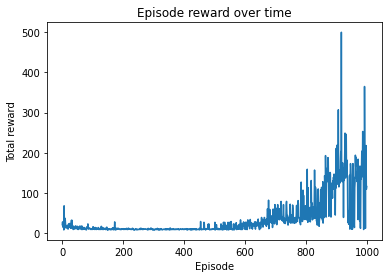

In [19]:

import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()


In [21]:
import pandas as pd
with open("tuning3.pickle", "rb") as f:
    object = pickle.load(f)
    
df = pd.DataFrame(object)
df.to_csv(r'file.csv')


In [17]:

#Defining the grid search that will go through different set of parametrs and return the average award for every set
#which will help tune the model by determing the best hyper parameters for The problem 

import pickle
n_hidden_options = [35, 40]
lr_options = [0.001, 0.003]
replay_size_options = [25,30, 35]
last_episode = 500


filename = 'tuning3.pickle'
for n_hidden in n_hidden_options:
    for lr in lr_options:
        for replay_size in replay_size_options:
            
              env.seed(1)
              random.seed(1)
              torch.manual_seed(1)

              dqn = DQN(n_state, n_action, n_hidden, lr)
              memory = deque(maxlen=10000)
              total_reward_episode = [0] * n_episode

              q_learning(env, dqn, n_episode, replay_size, gamma=.8, epsilon=1)
              
              avg=sum(total_reward_episode[-last_episode:])/last_episode
        
              avg=sum(total_reward_episode[-last_episode:])/last_episode
              print("Hidden layer: ",n_hidden, "lr: ",lr,"Replay size: ", replay_size, "AVG reward: ",avg)
              visual=n_hidden, lr, replay_size, avg
              pickle.dump(visual, open(filename, 'wb'))

Hidden layer:  35 lr:  0.001 Replay size:  25 AVG reward:  9.416
Hidden layer:  35 lr:  0.001 Replay size:  30 AVG reward:  9.714
Hidden layer:  35 lr:  0.001 Replay size:  35 AVG reward:  9.556
Hidden layer:  35 lr:  0.003 Replay size:  25 AVG reward:  15.954
Hidden layer:  35 lr:  0.003 Replay size:  30 AVG reward:  16.736
Hidden layer:  35 lr:  0.003 Replay size:  35 AVG reward:  11.206
Hidden layer:  40 lr:  0.001 Replay size:  25 AVG reward:  9.82
Hidden layer:  40 lr:  0.001 Replay size:  30 AVG reward:  9.754
Hidden layer:  40 lr:  0.001 Replay size:  35 AVG reward:  9.514
Hidden layer:  40 lr:  0.003 Replay size:  25 AVG reward:  120.942
Hidden layer:  40 lr:  0.003 Replay size:  30 AVG reward:  83.516
Hidden layer:  40 lr:  0.003 Replay size:  35 AVG reward:  91.952
